In [46]:
import os
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Download Models and data

In [4]:
# %%bash
# pwd
# cd /content/gdrive/My\ Drive/Software\ AI/inversecooking/dataset
# wget -q https://dl.fbaipublicfiles.com/inversecooking/ingr_vocab.pkl 
# wget -q https://dl.fbaipublicfiles.com/inversecooking/instr_vocab.pkl
# wget -q https://dl.fbaipublicfiles.com/inversecooking/modelbest.ckpt
# wget -q http://data.csail.mit.edu/im2recipe/recipe1M_layers.tar.gz
# wget -q http://data.csail.mit.edu/im2recipe/det_ingrs.json
# tar -xvzf recipe1M_layers.tar.gz
# rm -rf recipe1M_layers.tar.gz
# cd /content/gdrive/My\ Drive/Software\ AI/inversecooking/src/
# pwd

/content
layer1.json
layer2.json
/content/gdrive/My Drive/Software AI/inversecooking/src


## Inverse Cooking: Recipe Generation from Food Images

In [33]:
import os

workpath = '/content/gdrive/My Drive/Software AI/inversecooking/src/'
os.chdir(workpath)
os.getcwd()

'/content/gdrive/My Drive/Software AI/inversecooking/src'

In [0]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import numpy as np
from args import get_parser
import pickle
from model import get_model
from torchvision import transforms
from utils.output_utils import prepare_output
from PIL import Image
import time

Set ```data_dir``` to the path including vocabularies and model checkpoint

In [0]:
data_dir = '/content/gdrive/My Drive/Software AI/inversecooking/data'

In [15]:
# code will run in gpu if available and if the flag is set to True, else it will run on cpu
use_gpu = True
device = torch.device('cuda' if torch.cuda.is_available() and use_gpu else 'cpu')
map_loc = None if torch.cuda.is_available() and use_gpu else 'cpu'
torch.cuda.get_device_name(0)

'Tesla T4'

In [0]:
# code below was used to save vocab files so that they can be loaded without Vocabulary class
#ingrs_vocab = pickle.load(open(os.path.join(data_dir, 'final_recipe1m_vocab_ingrs.pkl'), 'rb'))
#ingrs_vocab = [min(w, key=len) if not isinstance(w, str) else w for w in ingrs_vocab.idx2word.values()]
#vocab = pickle.load(open(os.path.join(data_dir, 'final_recipe1m_vocab_toks.pkl'), 'rb')).idx2word
#pickle.dump(ingrs_vocab, open('../demo/ingr_vocab.pkl', 'wb'))
#pickle.dump(vocab, open('../demo/instr_vocab.pkl', 'wb'))

ingrs_vocab = pickle.load(open(os.path.join(data_dir, 'ingr_vocab.pkl'), 'rb'))
vocab = pickle.load(open(os.path.join(data_dir, 'instr_vocab.pkl'), 'rb'))

ingr_vocab_size = len(ingrs_vocab)
instrs_vocab_size = len(vocab)
output_dim = instrs_vocab_size

In [17]:
print (instrs_vocab_size, ingr_vocab_size)

23231 1488


In [18]:
t = time.time()
import sys; sys.argv=['']; del sys
args = get_parser()
args.maxseqlen = 15
args.ingrs_only=False
model = get_model(args, ingr_vocab_size, instrs_vocab_size)
# Load the trained model parameters
model_path = os.path.join(data_dir, 'modelbest.ckpt')
model.load_state_dict(torch.load(model_path, map_location=map_loc))
model.to(device)
model.eval()
model.ingrs_only = False
model.recipe_only = False
print ('loaded model')
print ("Elapsed time:", time.time() -t)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:01<00:00, 55587808.29it/s]
/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


loaded model
Elapsed time: 16.259603261947632


In [0]:
transf_list_batch = []
transf_list_batch.append(transforms.ToTensor())
transf_list_batch.append(transforms.Normalize((0.485, 0.456, 0.406), 
                                              (0.229, 0.224, 0.225)))
to_input_transf = transforms.Compose(transf_list_batch)

In [0]:
greedy = [True, False, False, False]
beam = [-1, -1, -1, -1]
temperature = 1.0
numgens = len(greedy)

Set ```use_urls = True``` to get recipes for images in ```demo_urls```. 

You can also set ```use_urls = False``` and get recipes for images in the path in ```data_dir/test_imgs```.

In [0]:
import requests
from io import BytesIO
import random
from collections import Counter
use_urls = False # set to true to load images from demo_urls instead of those in test_imgs folder
show_anyways = False #if True, it will show the recipe even if it's not valid
image_folder = os.path.join(data_dir, 'demo_imgs')

if not use_urls:
    demo_imgs = os.listdir(image_folder)
    random.shuffle(demo_imgs)

demo_urls = ['https://food.fnr.sndimg.com/content/dam/images/food/fullset/2013/12/9/0/FNK_Cheesecake_s4x3.jpg.rend.hgtvcom.826.620.suffix/1387411272847.jpeg',
            'https://www.196flavors.com/wp-content/uploads/2014/10/california-roll-3-FP.jpg']

demo_files = demo_urls if use_urls else demo_imgs

In [0]:
# for img_file in demo_files:
    
#     if use_urls:
#         response = requests.get(img_file)
#         image = Image.open(BytesIO(response.content))
#     else:
#         image_path = os.path.join(image_folder, img_file)
#         image = Image.open(image_path).convert('RGB')
    
#     transf_list = []
#     transf_list.append(transforms.Resize(256))
#     transf_list.append(transforms.CenterCrop(224))
#     transform = transforms.Compose(transf_list)
    
#     image_transf = transform(image)
#     image_tensor = to_input_transf(image_transf).unsqueeze(0).to(device)
    
#     plt.imshow(image_transf)
#     plt.axis('off')
#     plt.show()
#     plt.close()
    
#     num_valid = 1
#     for i in range(numgens):
#         with torch.no_grad():
#             outputs = model.sample(image_tensor, greedy=greedy[i], 
#                                    temperature=temperature, beam=beam[i], true_ingrs=None)
            
#         ingr_ids = outputs['ingr_ids'].cpu().numpy()
#         recipe_ids = outputs['recipe_ids'].cpu().numpy()
            
#         outs, valid = prepare_output(recipe_ids[0], ingr_ids[0], ingrs_vocab, vocab)
        
#         if valid['is_valid'] or show_anyways:
            
#             print ('RECIPE', num_valid)
#             num_valid+=1
#             #print ("greedy:", greedy[i], "beam:", beam[i])
    
#             BOLD = '\033[1m'
#             END = '\033[0m'
#             print (BOLD + '\nTitle:' + END,outs['title'])

#             print (BOLD + '\nIngredients:'+ END)
#             print (', '.join(outs['ingrs']))

#             print (BOLD + '\nInstructions:'+END)
#             print ('-'+'\n-'.join(outs['recipe']))

#             print ('='*20)

#         else:
#             pass
#             print ("Not a valid recipe!")
#             print ("Reason: ", valid['reason'])
        

Generating recipes for images: ['bife.png', 'paodealho.jpg']


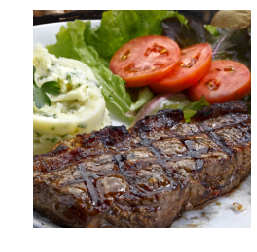

RECIPE 1

Title: Grilled sirloin steak with mustard sauce

Ingredients:
pepper, oil, steak, clove, salt, mustard, juice

Instructions:
-In a small bowl, combine the mustard, lemon juice, garlic, salt and pepper.
-Brush the steaks with the mustard mixture and let stand at room temperature for 30 minutes.
-Light a grill or preheat a grill pan.
-Grill the steaks over moderately high heat, turning once, until medium-rare, about 6 minutes for medium-rare.
-Transfer the steaks to a carving board and let rest for 5 minutes.
-Thinly slice the steaks.
-Serve the steaks with the mustard sauce.
RECIPE 2

Title: Grilled sirloin steaks with lemon aioli

Ingredients:
pepper, oil, steak, clove, salt, mustard, juice

Instructions:
-Light a grill or preheat a grill pan.
-In a large bowl, whisk together olive oil, lemon juice, garlic, mustard, and salt and pepper to taste.
-Add the steaks and turn to coat.
-Transfer the meat, fat side down and cook for 2 minutes, then turn the steaks over and cook for 2

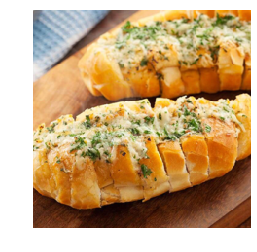

RECIPE 1

Title: Cheesy herb rolls

Ingredients:
cheese, butter, parsley, roll

Instructions:
-Heat oven to 375f.
-Unroll dough; separate into 8 triangles.
-Place 1 cheese triangle on each triangle; roll up.
-Place, seam-sides down, in 13x9-inch baking dish sprayed with cooking spray.
-Mix butter and parsley; brush over rolls.
-Bake 20 min.
-Or until golden brown.
RECIPE 2

Title: Cheese rolls in the microwave

Ingredients:
cheese, butter, parsley, roll

Instructions:
-In a microwave-safe bowl, cover the cheese with plastic wrap.
-Microwave on high until melted (30 seconds).
-Remove wrap and stir in the parsley and butter until combined.
-Fill the rolls with the cheese mixture.
RECIPE 3

Title: Parmesan herb rolls

Ingredients:
cheese, butter, parsley, roll

Instructions:
-Preheat oven to 375 f.
-Separate crescent dough into 8 triangles.
-Mix butter and cheeses together.
-Brush butter mixture on each triangle and roll up.
-Place on ungreased cookie sheet.
-Sprinkle with parsley flakes.

In [47]:
bbq_folder = data_dir + "/bbq_imgs/"
bbq_images = os.listdir(bbq_path)
print('Generating recipes for images:', bbq_images)

for img_file in bbq_images:
    if use_urls:
        response = requests.get(img_file)
        image = Image.open(BytesIO(response.content))
    else:
        image_path = os.path.join(bbq_folder, img_file)
        image = Image.open(image_path).convert('RGB')
    
    transf_list = []
    transf_list.append(transforms.Resize(256))
    transf_list.append(transforms.CenterCrop(224))
    transform = transforms.Compose(transf_list)
    
    image_transf = transform(image)
    image_tensor = to_input_transf(image_transf).unsqueeze(0).to(device)
    
    plt.imshow(image_transf)
    plt.axis('off')
    plt.show()
    plt.close()
    
    num_valid = 1
    for i in range(numgens):
        with torch.no_grad():
            outputs = model.sample(image_tensor, greedy=greedy[i], 
                                   temperature=temperature, beam=beam[i], true_ingrs=None)
            
        ingr_ids = outputs['ingr_ids'].cpu().numpy()
        recipe_ids = outputs['recipe_ids'].cpu().numpy()
            
        outs, valid = prepare_output(recipe_ids[0], ingr_ids[0], ingrs_vocab, vocab)
        
        if valid['is_valid'] or show_anyways:
            
            print ('RECIPE', num_valid)
            num_valid+=1
            #print ("greedy:", greedy[i], "beam:", beam[i])
    
            BOLD = '\033[1m'
            END = '\033[0m'
            print (BOLD + '\nTitle:' + END,outs['title'])

            print (BOLD + '\nIngredients:'+ END)
            print (', '.join(outs['ingrs']))

            print (BOLD + '\nInstructions:'+END)
            print ('-'+'\n-'.join(outs['recipe']))

            print ('='*20)

        else:
            pass
            print ("Not a valid recipe!")
            print ("Reason: ", valid['reason'])
        